In [1]:
import pandas as pd
from pathlib import Path

# 디렉토리 설정
processed_dir = Path("../data/processed")
csv_files = list(processed_dir.glob("*.csv"))

# 저장할 텍스트 파일 경로
output_txt = processed_dir / "processed_files_summary.txt"

# 결과 기록
with open(output_txt, "w", encoding="utf-8") as f:
    if not csv_files:
        f.write("❌ CSV 파일이 없습니다.\n")
    else:
        for file_path in csv_files:
            f.write(f"\n📁 파일명: {file_path.name}\n")
            try:
                df = pd.read_csv(file_path)
                f.write(f"🔢 shape: {df.shape}\n")
                f.write("🔑 컬럼 목록:\n")
                f.write(f"{df.columns.tolist()}\n")
                f.write("🧾 예시 5개:\n")
                f.write(df.head().to_string(index=False))
                f.write("\n" + "-"*60 + "\n")
            except Exception as e:
                f.write(f"❌ 파일 열기 실패: {e}\n")

print(f"✅ 결과가 저장되었습니다: {output_txt}")

✅ 결과가 저장되었습니다: ../data/processed/processed_files_summary.txt


In [5]:
# .xls 파일용
!pip install xlrd
# .xlsx 파일용
!pip install openpyxl

!pip install openpyxl xlrd


import pandas as pd
from pathlib import Path

# 디렉토리 설정
raw_dir = Path("../data/raw")
raw_files = list(raw_dir.glob("*.csv")) + list(raw_dir.glob("*.xls")) + list(raw_dir.glob("*.xlsx"))

# 저장할 텍스트 파일 경로
output_txt = raw_dir / "raw_files_summary.txt"

# 결과 기록
with open(output_txt, "w", encoding="utf-8") as f:
    if not raw_files:
        f.write("❌ 파일이 없습니다.\n")
    else:
        for file_path in raw_files:
            f.write(f"\n📁 파일명: {file_path.name}\n")
            try:
                if file_path.suffix == ".csv":
                    try:
                        df = pd.read_csv(file_path, encoding="utf-8")
                    except UnicodeDecodeError:
                        df = pd.read_csv(file_path, encoding="cp949")
                elif file_path.suffix == ".xls":
                    df = pd.read_excel(file_path, engine="xlrd")
                elif file_path.suffix == ".xlsx":
                    df = pd.read_excel(file_path, engine="openpyxl")
                else:
                    f.write("❌ 지원하지 않는 파일 형식입니다.\n")
                    continue

                f.write(f"🔢 shape: {df.shape}\n")
                f.write("🔑 컬럼 목록:\n")
                f.write(f"{df.columns.tolist()}\n")
                f.write("🧾 예시 5개:\n")
                f.write(df.head().to_string(index=False))
                f.write("\n" + "-"*60 + "\n")

            except Exception as e:
                f.write(f"❌ 파일 열기 실패: {e}\n")

print(f"✅ 결과가 저장되었습니다: {output_txt}")


/var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/ipykernel_99136/2708452441.py:31: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding="cp949")


✅ 결과가 저장되었습니다: ../data/raw/raw_files_summary.txt


In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# 📂 데이터 로드
env_station = pd.read_csv(
    "../data/raw/한국환경공단_전기차 충전소 위치 및 운영정보(충전소 ID 포함)_20230531.csv",
    encoding='cp949'  # 또는 'euc-kr'
)
grid = pd.read_csv("../data/processed/grid_system_processed.csv")

tqdm.pandas()

# ✅ 1. 결측치 제거 (주소, 위도경도 등 필수 정보 기준)
env_station = env_station.dropna(subset=["주소", "위도경도"])

# ✅ 2. '서울특별시' 데이터만 필터링
env_station = env_station[env_station["시도"] == "서울특별시"].copy()

# ✅ 3. 위도/경도 분리
env_station[['위도', '경도']] = env_station["위도경도"].str.split(",", expand=True).astype(float)

# ✅ 4. 가장 가까운 격자 grid_id 반환 함수 정의
def find_nearest_grid(lat, lon):
    dists = ((grid['center_lat'] - lat) ** 2 + (grid['center_lon'] - lon) ** 2)
    return grid.loc[dists.idxmin(), 'grid_id']

# ✅ 5. tqdm 적용하여 격자 매핑 수행
env_station['grid_id'] = env_station.progress_apply(
    lambda row: find_nearest_grid(row['위도'], row['경도']),
    axis=1
)

# ✅ 6. 필요한 컬럼만 정제
processed = env_station[[
    '설치년도', '시도', '군구', '주소', '충전소명',
    '시설구분(대)', '시설구분(소)', '기종(대)', '기종(소)',
    '운영기관(대)', '운영기관(소)', '충전기타입',
    '이용자제한', '위도', '경도', 'grid_id'
]].copy()

# ✅ 7. 결과 저장
output_path = "../data/processed/charging_stations_seoul_gridded.csv"
processed.to_csv(output_path, index=False)
print(f"✅ 저장 완료: {output_path}")

/var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/ipykernel_71035/1158136360.py:6: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  env_station = pd.read_csv(
100%|██████████| 56351/56351 [00:09<00:00, 6170.53it/s]


✅ 저장 완료: ../data/processed/charging_stations_seoul_gridded.csv


📈 불균형 점수 요약:
count    6030.000000
mean        1.931382
std         6.249614
min         0.000000
25%         0.000000
50%         0.000000
75%         0.466189
max       117.706487
Name: imbalance_score, dtype: float64


/var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/ipykernel_1785/3208051797.py:30: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/ipykernel_1785/3208051797.py:30: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/ipykernel_1785/3208051797.py:30: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/ipykernel_1785/3208051797.py:30: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/ipykernel_1785/3208051797.py:30: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/ipykernel_178

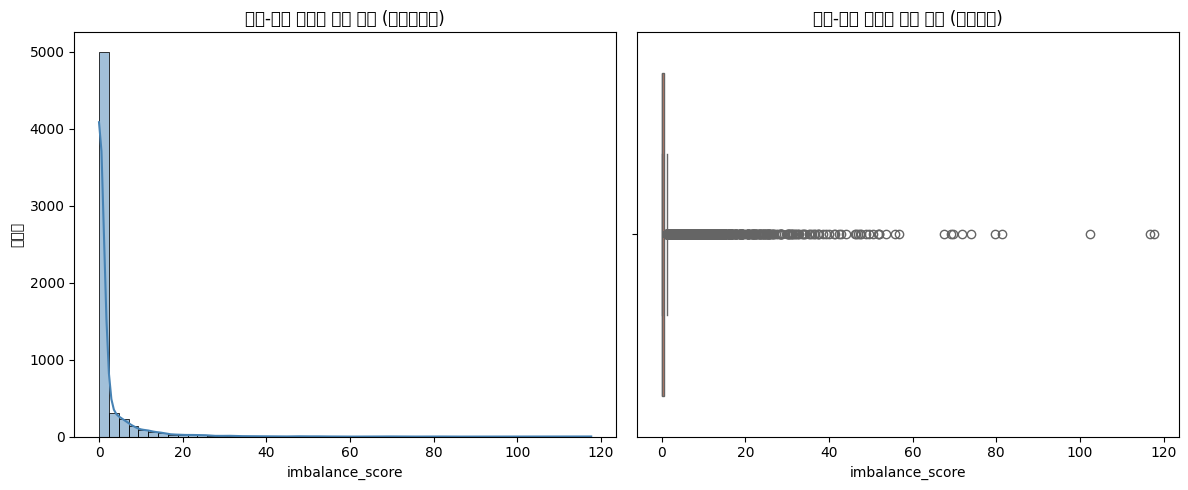

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 📂 파일 경로
file_path = "../data/processed/demand_supply_analysis.csv"

# 📊 데이터 로드
df = pd.read_csv(file_path)

# ✅ imbalance_score 기본 통계 출력
print("📈 불균형 점수 요약:")
print(df["imbalance_score"].describe())

# ✅ 시각화 설정
plt.figure(figsize=(12, 5))

# 🔹 히스토그램
plt.subplot(1, 2, 1)
sns.histplot(df["imbalance_score"], bins=50, kde=True, color="steelblue")
plt.title("수요-공급 불균형 점수 분포 (히스토그램)")
plt.xlabel("imbalance_score")
plt.ylabel("빈도수")

# 🔸 박스플롯
plt.subplot(1, 2, 2)
sns.boxplot(x=df["imbalance_score"], color="coral")
plt.title("수요-공급 불균형 점수 분포 (박스플롯)")

plt.tight_layout()
plt.show()

In [ ]:
grid_df = pd.read_csv("../data/processed/grid_system_processed.csv")
import pandas as pd

# 데이터 로드
stations_all = pd.read_csv("../data/processed/charging_stations_processed.csv")

# 서울시만 필터링
stations_seoul = stations_all[stations_all["시도"] == "서울특별시"].copy()


In [4]:
from tqdm import tqdm

def assign_grid_id(lat, lon, grid_df):
    for _, row in grid_df.iterrows():
        if row['min_lat'] <= lat <= row['max_lat'] and row['min_lon'] <= lon <= row['max_lon']:
            return row['grid_id']
    return None  # 매칭 안 되는 경우

stations = pd.read_csv("../data/processed/charging_stations_processed.csv")
stations['위도'] = pd.to_numeric(stations['위도'], errors='coerce')
stations['경도'] = pd.to_numeric(stations['경도'], errors='coerce')

tqdm.pandas()
stations['grid_id'] = stations.progress_apply(
    lambda row: assign_grid_id(row['위도'], row['경도'], grid_df),
    axis=1
)


KeyError: '위도'